# Estimating Stock Price Correlations using Wikipedia

FTSE 100 Index analysis using Wikipedia data

In [61]:
%matplotlib inline

from IPython.display import display

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas_datareader import data, wb
from gensim.models import Word2Vec
from itertools import combinations
from sklearn import linear_model
import seaborn as sns

sns.set(style="ticks")

### The Dataset

In [5]:
df_ftse_100_companies = pd.read_csv("ftse_100_companies.tsv", sep='\t')
df_ftse_100_companies.head()

,Company,Ticker,Sector,Market cap,Employees
0,3i,III,Private equity,4.06,266
1,Aberdeen Asset Management,ADN,Fund management,3.14,"1,800"
2,Admiral Group,ADM,Insurance,4.91,"2,500"
3,Anglo American plc,AAL,Mining,6.09,"100,000"
4,Antofagasta PLC,ANTO,Mining,4.71,"4,005"


Data preparation - normalizing company names

In [6]:
df_ftse_100_companies.loc[:, 'Company Preprocess'] = df_ftse_100_companies.loc[:, 'Company'].str.replace(' ', '_')
df_ftse_100_companies.head()

,Company,Ticker,Sector,Market cap,Employees,Company Preprocess
0,3i,III,Private equity,4.06,266,3i
1,Aberdeen Asset Management,ADN,Fund management,3.14,"1,800",Aberdeen_Asset_Management
2,Admiral Group,ADM,Insurance,4.91,"2,500",Admiral_Group
3,Anglo American plc,AAL,Mining,6.09,"100,000",Anglo_American_plc
4,Antofagasta PLC,ANTO,Mining,4.71,"4,005",Antofagasta_PLC


In [8]:
df_ftse_100_companies.to_csv('ftse_100_companies_preprocess.csv', index=0)

In [9]:
ftse_100_companies_list = df_ftse_100_companies['Company Preprocess'].tolist()

Company pair combinations

In [30]:
ftse_100_company_pairs = combinations(ftse_100_companies_list, 2)

In [31]:
df_ftse_100_company_pairs = pd.DataFrame(list(ftse_100_company_pairs))
df_ftse_100_company_pairs.columns = ['Company1', 'Company2']
df_ftse_100_company_pairs.head()

,Company1,Company2
0,3i,Aberdeen_Asset_Management
1,3i,Admiral_Group
2,3i,Anglo_American_plc
3,3i,Antofagasta_PLC
4,3i,ARM_Holdings


In [32]:
df_ftse_100_company_pairs.to_csv('ftse_100_company_pairs.csv', index=0)

### Load Wiki2Vec model in Gensim

A pre-built wiki2vec model for gensim can be found here: 

https://github.com/idio/wiki2vec

The wiki2vec model can be loaded in gensim via the Word2Vec class.

In [4]:
model = Word2Vec.load("en_1000_no_stem/en.model")

### Word2Vec Similarity Computation

Generate similarities (takes a bit)

In [83]:
def expand_company_name_dbpedia_id(company_name):
    return '/'.join(['DBPEDIA_ID', company_name])

In [84]:
def company_similarity(company1, company2):
    try:
        company1_dbp = expand_company_name_dbpedia_id(company1)
        company2_dbp = expand_company_name_dbpedia_id(company2)
        return model.similarity(company1_dbp, company2_dbp)
    except KeyError:
        return np.nan

In [ ]:
df_ftse_100_company_pairs.loc[:, 'W2V Similarity'] = df_ftse_100_company_pairs.apply(
    lambda row: company_similarity(row['Company1'], row['Company2']), axis=1)

In [88]:
df_ftse_100_company_pairs.to_csv('ftse_100_company_pairs_similarities.csv', index=0)

Or load pre-computed Word2Vec similarities

In [43]:
df_ftse_100_company_pairs = pd.read_csv('ftse_100_company_pairs_similarities_w2v.csv')
df_ftse_100_company_pairs.head(20)

,Company1,Company2,W2V Similarity
0,3i,Aberdeen_Asset_Management,NaN
1,3i,Admiral_Group,NaN
2,3i,Anglo_American_plc,0.399286
3,3i,Antofagasta_PLC,NaN
4,3i,ARM_Holdings,0.267260
5,3i,Ashtead_Group,NaN
6,3i,Associated_British_Foods,0.298811
7,3i,AstraZeneca,0.282113
8,3i,Aviva,0.403399
9,3i,Babcock_International,NaN


### Preparing Pricing Data 

Read daily closing price and compute daily returns

In [18]:
def read_daily_close(company_ticker):
    if company_ticker.endswith('.'):
        symbol = company_ticker + 'L'
    else:
        company_ticker = company_ticker.replace('.', '-')
        symbol = '.'.join([company_ticker, 'L'])
    df_company_close = data.YahooDailyReader(symbols=symbol, start='2013-1-1').read()
    
    return df_company_close    

In [19]:
def company_return(company_ticker):
    df_company = read_daily_close(company_ticker)
    
    df_company.loc[:, 'Close_Shift_1'] = df_company.loc[:, 'Close'].shift(1)
    df_company.loc[:, 'Return'] = df_company.loc[:, 'Close']/df_company.loc[:, 'Close_Shift_1'] - 1
    
    return df_company

In [38]:
company_dataframes = [company_return(company['Ticker']) for _, company in df_ftse_100_companies.iterrows()]

In [39]:
company_return_series = [df['Return'] for df in company_dataframes]
df_returns = pd.concat(company_return_series, axis=1)
df_returns.columns = [' '.join(['Return', company['Ticker']]) for _, company in df_ftse_100_companies.iterrows()]

In [40]:
df_correlations = df_returns.corr()
df_correlations

,Return III,Return ADN,Return ADM,Return AAL,Return ANTO,Return ARM,Return AHT,Return ABF,Return AZN,Return AV.,...,Return TSCO,Return TPK,Return TUI,Return ULVR,Return UU,Return VOD,Return WTB,Return WOS,Return WPG,Return WPP
Return III,1.000000,-0.022297,0.017091,0.038954,0.012840,0.027753,0.001395,0.058020,0.002335,-0.004299,...,0.014294,0.065668,-0.007334,-0.009507,0.010463,0.028495,0.032636,0.043466,0.079638,0.041479
Return ADN,-0.022297,1.000000,0.254924,0.438997,0.419967,0.381012,0.428062,0.317886,0.269457,0.444428,...,0.323581,0.424352,0.353071,0.410472,0.310793,0.150428,0.427013,0.443791,0.295301,0.486424
Return ADM,0.017091,0.254924,1.000000,0.160431,0.160885,0.257300,0.239361,0.295942,0.283621,0.336457,...,0.260192,0.308163,0.312961,0.392992,0.280619,0.127832,0.276439,0.340703,0.270386,0.387547
Return AAL,0.038954,0.438997,0.160431,1.000000,0.754940,0.204603,0.268317,0.144858,0.120494,0.310349,...,0.291821,0.224959,0.145104,0.193075,0.145965,0.071971,0.152277,0.281533,0.221425,0.237284
Return ANTO,0.012840,0.419967,0.160885,0.754940,1.000000,0.212740,0.303032,0.125838,0.133805,0.320666,...,0.277201,0.235430,0.170176,0.213080,0.190542,0.059399,0.172282,0.276008,0.200021,0.264202
Return ARM,0.027753,0.381012,0.257300,0.204603,0.212740,1.000000,0.393198,0.279942,0.280546,0.375226,...,0.240145,0.432217,0.348919,0.388076,0.277754,0.181756,0.406512,0.455197,0.264051,0.493365
Return AHT,0.001395,0.428062,0.239361,0.268317,0.303032,0.393198,1.000000,0.355060,0.292848,0.367691,...,0.193609,0.493525,0.288756,0.334995,0.295919,0.175181,0.427125,0.513212,0.242174,0.509047
Return ABF,0.058020,0.317886,0.295942,0.144858,0.125838,0.279942,0.355060,1.000000,0.309682,0.363675,...,0.268493,0.345996,0.362319,0.503408,0.344931,0.077610,0.398227,0.404541,0.329293,0.428156
Return AZN,0.002335,0.269457,0.283621,0.120494,0.133805,0.280546,0.292848,0.309682,1.000000,0.326031,...,0.263878,0.321106,0.328918,0.475942,0.356209,0.204973,0.340375,0.359031,0.432174,0.425338
Return AV.,-0.004299,0.444428,0.336457,0.310349,0.320666,0.375226,0.367691,0.363675,0.326031,1.000000,...,0.321541,0.460024,0.391942,0.396721,0.335281,0.210465,0.429089,0.490014,0.506332,0.493959


Obtain pairwise correlations

In [41]:
pairwise_correlations = []
for i in range(100):
    for j in range(100):
        if j > i:
            pairwise_correlations.append(df_correlations.iloc[i][j])
len(pairwise_correlations)

4950

In [44]:
df_ftse_100_company_pairs.loc[:, 'Correlation'] = pd.Series(pairwise_correlations).T
df_ftse_100_company_pairs.head(20)

,Company1,Company2,W2V Similarity,Correlation
0,3i,Aberdeen_Asset_Management,NaN,-0.022297
1,3i,Admiral_Group,NaN,0.017091
2,3i,Anglo_American_plc,0.399286,0.038954
3,3i,Antofagasta_PLC,NaN,0.012840
4,3i,ARM_Holdings,0.267260,0.027753
5,3i,Ashtead_Group,NaN,0.001395
6,3i,Associated_British_Foods,0.298811,0.058020
7,3i,AstraZeneca,0.282113,0.002335
8,3i,Aviva,0.403399,-0.004299
9,3i,Babcock_International,NaN,0.018397


In [46]:
df_ftse_100_company_pairs = df_ftse_100_company_pairs.dropna()
df_ftse_100_company_pairs.describe()

,W2V Similarity,Correlation
count,2016.000000,2016.000000
mean,0.274321,0.324598
std,0.085149,0.129776
min,0.006439,-0.056365
25%,0.216908,0.254911
50%,0.272464,0.337338
75%,0.325629,0.404077
max,0.676350,0.860583


### Does the Wikipedia Similarity Explain Correlation of Returns?

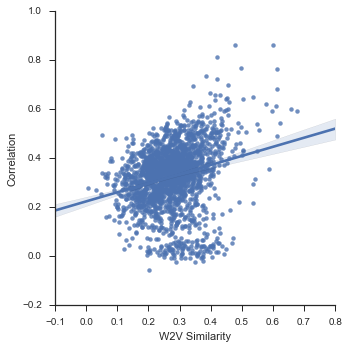

In [51]:
sns.lmplot("W2V Similarity", "Correlation", data=df_ftse_100_company_pairs)

In [59]:
clf = linear_model.LinearRegression()

In [63]:
def r2_by_market_cap(min_market_cap):
    df_ftse_100_companies_mkt_cap = df_ftse_100_companies.loc[
        df_ftse_100_companies['Market cap'] > min_market_cap]
    
    df_ftse_100_company_pairs_mkt_cap = df_ftse_100_company_pairs.loc[
        df_ftse_100_company_pairs['Company1'].isin(df_ftse_100_companies_mkt_cap['Company Preprocess']) & 
        df_ftse_100_company_pairs['Company2'].isin(df_ftse_100_companies_mkt_cap['Company Preprocess'])].copy()
    
    clf.fit(df_ftse_100_company_pairs_mkt_cap['W2V Similarity'].reshape(-1, 1), 
            df_ftse_100_company_pairs_mkt_cap['Correlation'].reshape(-1, 1))
    
    r2 = clf.score(df_ftse_100_company_pairs_mkt_cap['W2V Similarity'].reshape(-1, 1), 
                   df_ftse_100_company_pairs_mkt_cap['Correlation'].reshape(-1, 1))
    
    display('{0} company pairs having r2 = {1} with market_cap greater than {2}'.format(
             len(df_ftse_100_company_pairs_mkt_cap), r2, min_market_cap))
    
    return df_ftse_100_company_pairs_mkt_cap

In [64]:
df_market_cap = r2_by_market_cap(0.0)

'2016 company pairs having r2 = 0.0595084752758 with market_cap greater than 0.0'

In [65]:
df_market_cap_7 = r2_by_market_cap(7.0)

'861 company pairs having r2 = 0.17858696092 with market_cap greater than 7.0'

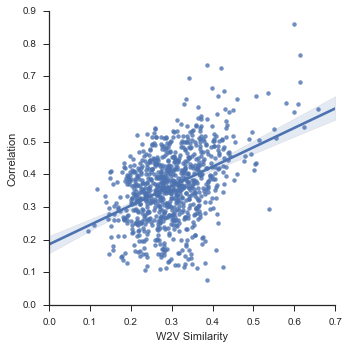

In [66]:
sns.lmplot("W2V Similarity", "Correlation", data=df_market_cap_7)

In [67]:
df_market_cap_12 = r2_by_market_cap(12.0)

'465 company pairs having r2 = 0.332926590094 with market_cap greater than 12.0'

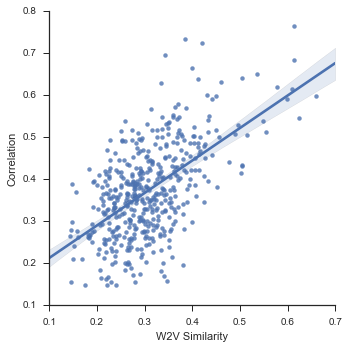

In [68]:
sns.lmplot("W2V Similarity", "Correlation", data=df_market_cap_12)